In [1]:
# 1. create config with all the stuff necessary below
from omegaconf import DictConfig, OmegaConf
cfg = OmegaConf.create(
        dict(
            aggregation_method="mean",
            model_name="random_forest",
            model_kwargs=dict(
                numberOfTrees=100,
                minLeafPopulation=3,
                maxNodes=1e4,
            ),
            data=dict(
                aois_test=[f"UKR{i}" for i in range(1, 19) if i not in [1, 2, 3, 4]],
                damages_to_keep=[1, 2],
                extract_winds=["3x3"],  # ['1x1', '3x3', '5x5']
                time_periods={  # to train
                    "pre": ("2020-02-24", "2021-02-23"),  # always only one
                    "post": "3months",
                },
            ),
            inference=dict(
                time_periods={
                    "pre": ("2020-02-24", "2021-02-23"),  # always only one
                    "post": [
                        ("2021-02-24", "2021-05-23"),
                        ("2021-05-24", "2021-08-23")#,
                        #("2021-08-24", "2021-11-23"),
                        #("2021-11-24", "2022-02-23"),
                        #("2022-02-24", "2022-05-23"),
                        #("2022-05-24", "2022-08-23"),
                        #("2022-08-24", "2022-11-23"),
                        #("2022-11-24", "2023-02-23"),
                    ],
                },
                quadkey_zoom=8,
            ),
            reducer_names=["mean", "stdDev", "median", "min", "max", "skew", "kurtosis"],
            train_on_all=False,  # train on all damages (train + test split)
            verbose=0,
            export_as_trees=False,
            seed=123,
            run_name="240307",  # must be string
        )
    )

#TODO adapt for other countries: time_periods and include identifier for AOIs of other countries? or just have different configs for the different cases? 

In [2]:
# 2. 
from src.data import quadkeys

In [3]:
# 2.1 create quadkeys for region you want
#quadkeys.create_ukraine_quadkeys_grid(zoom=cfg.inference.quadkey_zoom) 
#SOLVED BY CREATING THE QUADKEY LIST INDEPENDT OF DOWNLOADED MICROSOFT BUILDING FILES // funktioniert noch nicht weil die quadkeys basierend auf den heruntergeladenen microsoft building footprints erstellt werden - und das habe ich bisher nur für Ukraine gemacht - selbst das overture script bezieht sich für die frage welche quadkeys (in dem fall) ukraine abdecken auf die filenames der heruntergeladenden microsoft building footprints...
quadkeys.create_country_quadkeys_grid(zoom=cfg.inference.quadkey_zoom, country="Syria") 
# creates quadkeys and saves as file

Creating quadkey grid with zoom = 8...
Quadkey grid with zoom = 8 saved.
create_country_quadkeys_grid executed in 3.22s


In [4]:
# 2.2 load all quadkeys for region you want
#gdf_qk = quadkeys.load_ukraine_quadkeys_grid(zoom=cfg.inference.quadkey_zoom)
gdf_qk = quadkeys.load_country_quadkeys_grid(zoom=cfg.inference.quadkey_zoom, country="Syria")
gdf_qk 

,qk,area_in_syria,geometry
0,12211032,0.114720,"POLYGON ((37.96875 36.59789, 36.58550 36.59789..."
1,12211033,0.165394,"POLYGON ((39.37500 36.59789, 37.96875 36.59789..."
2,12211122,0.246009,"POLYGON ((40.78125 36.59789, 39.37500 36.59789..."
3,12211123,0.436240,"POLYGON ((40.78125 36.59789, 40.78125 37.12157..."
4,12211132,0.029704,"POLYGON ((42.18750 37.29087, 42.18762 37.29102..."
5,12211201,0.349522,"MULTIPOLYGON (((36.56250 35.46067, 35.52164 35..."
6,12211203,0.489234,"MULTIPOLYGON (((36.56250 34.31991, 36.56194 34..."
7,12211210,0.989393,"POLYGON ((37.96875 36.59789, 37.96875 35.46067..."
8,12211211,1.000000,"POLYGON ((37.96875 35.46067, 39.37500 35.46067..."
9,12211212,0.999759,"POLYGON ((36.56250 35.46067, 37.96875 35.46067..."


In [5]:
# 3. initialize connection with GEE
import ee
from src.utils.gee import init_gee
init_gee() 

In [6]:
# 3.1 add column with ee.Geometries() which is necessary for applying the algorithm
from shapely.geometry import mapping
gdf_qk["geomee"] = gdf_qk.apply(lambda x: ee.Geometry(mapping(x['geometry'])), axis = 1)
gdf_qk

,qk,area_in_syria,geometry,geomee
0,12211032,0.114720,"POLYGON ((37.96875 36.59789, 36.58550 36.59789...","ee.Geometry({\n ""functionInvocationValue"": {\..."
1,12211033,0.165394,"POLYGON ((39.37500 36.59789, 37.96875 36.59789...","ee.Geometry({\n ""functionInvocationValue"": {\..."
2,12211122,0.246009,"POLYGON ((40.78125 36.59789, 39.37500 36.59789...","ee.Geometry({\n ""functionInvocationValue"": {\..."
3,12211123,0.436240,"POLYGON ((40.78125 36.59789, 40.78125 37.12157...","ee.Geometry({\n ""functionInvocationValue"": {\..."
4,12211132,0.029704,"POLYGON ((42.18750 37.29087, 42.18762 37.29102...","ee.Geometry({\n ""functionInvocationValue"": {\..."
5,12211201,0.349522,"MULTIPOLYGON (((36.56250 35.46067, 35.52164 35...","ee.Geometry({\n ""functionInvocationValue"": {\..."
6,12211203,0.489234,"MULTIPOLYGON (((36.56250 34.31991, 36.56194 34...","ee.Geometry({\n ""functionInvocationValue"": {\..."
7,12211210,0.989393,"POLYGON ((37.96875 36.59789, 37.96875 35.46067...","ee.Geometry({\n ""functionInvocationValue"": {\..."
8,12211211,1.000000,"POLYGON ((37.96875 35.46067, 39.37500 35.46067...","ee.Geometry({\n ""functionInvocationValue"": {\..."
9,12211212,0.999759,"POLYGON ((36.56250 35.46067, 37.96875 35.46067...","ee.Geometry({\n ""functionInvocationValue"": {\..."


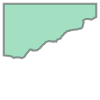

In [7]:
gdf_qk.iloc[15]['geometry']

In [8]:
gdf_qk.iloc[15]['geomee']

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              36.5625,
              33.137551192346145
            ],
            [
              37.96875,
              33.137551192346145
            ],
            [
              37.96875,
              32.93565312797626
            ],
            [
              37.9653981,
              32.9338419
            ],
            [
              37.945095,
              32.92296
            ],
            [
              37.915992,
              32.9068091
            ],
            [
              37.901525,
              32.8983584
            ],
            [
              37.8884179,
              32.8939411
            ],
            [
              37.8673941,
              32.9035823
            ],
            [
              37.8180372,
              32.9053839
            ],
            [
              37.8031112,
              32.9001233
            ],
            [
              37.7854473,
              32.89343
            ],
            [
              37.7693326,
              32.8787228
            ],
            [
              37.7754609,
              32.8679854
            ],
            [
              37.7765241,
              32.8513452
            ],
            [
              37.7742453,
              32.8427698
            ],
            [
              37.7716682,
              32.834555
            ],
            [
              37.7706286,
              32.8258823
            ],
            [
              37.7670849,
              32.8130972
            ],
            [
              37.764025,
              32.7989908
            ],
            [
              37.7621711,
              32.7878578
            ],
            [
              37.7533423,
              32.7744637
            ],
            [
              37.740796,
              32.7618001
            ],
            [
              37.7244549,
              32.7600634
            ],
            [
              37.7166668,
              32.7576959
            ],
            [
              37.7075312,
              32.7578294
            ],
            [
              37.7021775,
              32.7543665
            ],
            [
              37.6981542,
              32.7531881
            ],
            [
              37.6867184,
              32.7474122
            ],
            [
              37.6577598,
              32.7436236
            ],
            [
              37.6473907,
              32.744216
            ],
            [
              37.6062564,
              32.7374243
            ],
            [
              37.5819212,
              32.7337169
            ],
            [
              37.5667957,
              32.7332187
            ],
            [
              37.5622896,
              32.724408
            ],
            [
              37.5356349,
              32.7217273
            ],
            [
              37.5205287,
              32.7175011
            ],
            [
              37.5078987,
              32.6995452
            ],
            [
              37.4940757,
              32.6925533
            ],
            [
              37.4854733,
              32.6896441
            ],
            [
              37.4740471,
              32.668229
            ],
            [
              37.4648417,
              32.6580299
            ],
            [
              37.4442467,
              32.6429477
            ],
            [
              37.4352581,
              32.6226491
            ],
            [
              37.424555,
              32.6069518
            ],
            [
              37.3791119,
              32.5920942
            ],
            [
              37.3673467,
              32.5753934
            ],
            [
              37.3599159,
              32.560

In [9]:
# 4. load trained model from GEE assets
from src.gee.classification.model import load_classifier
asset_id = "projects/rmac-ethz/assets/s1tsdd_Ukraine/240307/classifier_3months_100trees"
classifier = load_classifier(asset_id) #load trained classifier (by olivier) from GEE assets

In [10]:
# 5. ####### NEW - TO WORK FOR OTHER REGIONS FLEXIBLY ######

from typing import List
from tqdm import tqdm

from src.gee.constants import ASSETS_PATH
from src.gee.classification.inference import predict_geo
# from src.utils.gdrive import get_files_in_folder #TODO had to remove this bc linked to pydrive

def predict_and_export_all_grids(
    classifier: ee.Classifier,
    cfg: DictConfig,
    folder: str,
    ids: List[str] = None,
    n_limit: int = None,
    verbose: int = 0,
):
    """
    Predict and export for all grids (quadkeys) in Ukraine.

    If ids is not None, predict only these grids. If n_limit is given, only predict on n_limit grids.
    """

    # Get all grids
    print(f"Predicting for quadkey grid with zoom {cfg.inference.quadkey_zoom}")
    # grids = ee.FeatureCollection(ASSETS_PATH + f"s1tsdd_Ukraine/quadkeys_grid_zoom{cfg.inference.quadkey_zoom}") 
    # instead: works for quadkey COUNTRY grid as defined before: 
    grids = gdf_qk

    # if ids is None:
    #     # No IDs were given, we predict on all (or n_limit if given)
    #     if n_limit:
    #         # For debugging
    #         grids = grids.limit(n_limit)
    #     ids = grids.aggregate_array("qk").getInfo()
    # else:
    #     # make sure ids are strings
    #     ids = [str(id_) for id_ in ids]

    # Filter IDs that have already been predicted (names are qk_12345678.tif for instance) #TODO removed bc reliant on pydrive which doesnt work atm
    # files = get_files_in_folder(folder, return_names=True)
    # existing_names = [f.split(".")[0] for f in files if f.startswith("qk_")]
    # ids = [id_ for id_ in ids if id_ not in existing_names]

    # get operations still running
    def get_description(id_):
        return f"{cfg.run_name}_qk{id_}_{'_'.join(cfg.inference.time_periods.post)}"

    # ops = [o for o in ee.data.listOperations() if o["metadata"]["state"] in ["PENDING", "RUNNING"]]
    # ids_running = [o["metadata"]["description"] for o in ops]
    # ids = [id_ for id_ in ids if get_description(id_) not in ids_running]

    print(f"Predicting and exporting {len(grids)} grids")
    for i in tqdm(range(len(grids))):

        grid = grids.iloc[i]
        preds = predict_geo(
            grid.geomee,
            classifier,
            cfg.inference.time_periods,
            cfg.data.extract_winds,
            cfg.reducer_names,
            orbits=None,
            verbose=verbose,
        )
        preds = preds.set("qk", grid.qk)

        name = f"qk_{grid.qk}"
        task = ee.batch.Export.image.toDrive(
            image=preds.multiply(2**8 - 1).toUint8(),  # multiply by 255 and convert to uint8
            description=get_description(grid.qk),
            folder=folder,
            fileNamePrefix=name,
            region=grid.geomee,
            scale=10,
            maxPixels=1e13,
        )
        task.start()

In [ ]:
####### OLD / ADAPTED FROM OLIVIER / ONLY WORKS FOR UKRAINE ######

from typing import List
from tqdm import tqdm

from src.gee.constants import ASSETS_PATH
from src.gee.classification.inference import predict_geo
# from src.utils.gdrive import get_files_in_folder #TODO had to remove this bc linked to pydrive

def predict_and_export_all_grids(
    classifier: ee.Classifier,
    cfg: DictConfig,
    folder: str,
    ids: List[str] = None,
    n_limit: int = None,
    verbose: int = 0,
):
    """
    Predict and export for all grids (quadkeys) in Ukraine.

    If ids is not None, predict only these grids. If n_limit is given, only predict on n_limit grids.
    """

    # Get all grids
    print(f"Predicting for quadkey grid with zoom {cfg.inference.quadkey_zoom}")
    grids = ee.FeatureCollection(ASSETS_PATH + f"s1tsdd_Ukraine/quadkeys_grid_zoom{cfg.inference.quadkey_zoom}") #TODO how to adapt this for other countries? could I also get this from elsewhere? 
    #TODO turn quadkeys for other regions (clipped to country or AOI borders) into ee.FeatureCollection (check birke_test.ipynb for this)
    #OR doesnt necessarily have to work with quadkeys - could also just create ee.FeatureCollection of areas I want to co
    # ver (e.g. all AOIs) through which I can loop later

    if ids is None:
        # No IDs were given, we predict on all (or n_limit if given)
        if n_limit:
            # For debugging
            grids = grids.limit(n_limit)
        ids = grids.aggregate_array("qk").getInfo()
    else:
        # make sure ids are strings
        ids = [str(id_) for id_ in ids]

    # Filter IDs that have already been predicted (names are qk_12345678.tif for instance) #TODO removed bc reliant on pydrive which doesnt work atm
    # files = get_files_in_folder(folder, return_names=True)
    # existing_names = [f.split(".")[0] for f in files if f.startswith("qk_")]
    # ids = [id_ for id_ in ids if id_ not in existing_names]

    # get operations still running
    def get_description(id_):
        return f"{cfg.run_name}_qk{id_}_{'_'.join(cfg.inference.time_periods.post)}"

    ops = [o for o in ee.data.listOperations() if o["metadata"]["state"] in ["PENDING", "RUNNING"]]
    ids_running = [o["metadata"]["description"] for o in ops]
    ids = [id_ for id_ in ids if get_description(id_) not in ids_running]

    print(f"Predicting and exporting {len(ids)} grids")
    for id_ in tqdm(ids):

        grid = grids.filter(ee.Filter.eq("qk", id_))
        preds = predict_geo(
            grid.geometry(),
            classifier,
            cfg.inference.time_periods,
            cfg.data.extract_winds,
            cfg.reducer_names,
            orbits=None,
            verbose=verbose,
        )
        preds = preds.set("qk", id_)

        name = f"qk_{id_}"
        task = ee.batch.Export.image.toDrive(
            image=preds.multiply(2**8 - 1).toUint8(),  # multiply by 255 and convert to uint8
            description=get_description(id_),
            folder=folder,
            fileNamePrefix=name,
            region=grid.geometry(),
            scale=10,
            maxPixels=1e13,
        )
        task.start()

In [11]:
# 6. apply function 
# from src.gee.classification.ukraine_full_prediction import predict_and_export_all_grids #TODO atm use function from above instead that doesnt rely on pydrive
# TODO incl. creating separate folders etc. for different quadkeys BUT atm cannot download client id - solved this for now by creating folders manually
# from src.utils.gdrive import create_drive_folder, create_yaml_file_in_drive_from_config_dict
base_folder_name = f"{cfg.run_name}_quadkeys_predictions"
# try:
#     # Create drive folder and save config
#     create_drive_folder(base_folder_name)
#     create_yaml_file_in_drive_from_config_dict(cfg, base_folder_name)
# except Exception:
#     # get input from user to be sure they want to continue
#     print("Folder already exists. Continue? (y/n)")
#     user_input = input()
#     if user_input != "y":
#         raise ValueError("Interrupted")

post_periods = cfg.inference.time_periods.post

for post_period in post_periods:

    folder_name = f"{base_folder_name}/{'_'.join(post_period)}"
    cfg.inference.time_periods.post = post_period
    # try:
    #         # Create drive folder and save config
    #     create_drive_folder(folder_name)
    # except Exception:
    #         # get input from user to be sure they want to continue
    #     print("Folder already exists. Continue? (y/n)")
    #     user_input = input()
    #     if user_input != "y":
    #         raise ValueError("Interrupted")

        # Launch predictions
    predict_and_export_all_grids(
        classifier=classifier,
        cfg=cfg,
        folder=folder_name.split("/")[-1], 
        ids=None,
        n_limit=None,
        verbose=cfg.verbose,
    )

Predicting for quadkey grid with zoom 8
Predicting and exporting 21 grids


100%|██████████| 21/21 [00:25<00:00,  1.19s/it]


Predicting for quadkey grid with zoom 8
Predicting and exporting 21 grids


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


In [ ]:
#TODO: stitch quadkeys back together / link them with UNOSAT labels in order to evaluate them 
#might make sense to put them into a geodatabase -> have in different tables the links with admin regions, AOIs, and buildings maybe? => ON HOLD

In [ ]:
from src.postprocessing.utils import read_fp_within_geo 
from src.constants import PREDS_PATH
from src.utils.geometry import load_country_boundaries

ukr_geo = load_country_boundaries("Ukraine")
fp = PREDS_PATH / cfg.run_name / "qk_12021333.tif"
preds_arr = read_fp_within_geo(fp, ukr_geo)
preds_arr

In [ ]:
preds_arr.plot()

In [ ]:
"hslaDajsf".lower()